<a href="https://colab.research.google.com/github/Nuri-Tas/NLP/blob/main/Text%20Classification/Poem_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import string
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
!wget -nc https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/edgar_allan_poe.txt
!wget -nc https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt

File ‘edgar_allan_poe.txt’ already there; not retrieving.

File ‘robert_frost.txt’ already there; not retrieving.



In [ ]:
inputs = []
labels = []

files = ["/content/edgar_allan_poe.txt", "/content/robert_frost.txt"]

for label, path in enumerate(files):
  print(f"Label {label} corresponds to {path.split('/')[-1][:-4]}")

  for line in open(path):
    row = line.strip().lower()
    if row:
      inputs.append(row.translate(str.maketrans("", "", string.punctuation)))
      labels.append(label)

Label 0 corresponds to edgar_allan_poe
Label 1 corresponds to robert_frost


We perform train/test split before proceeding to create markov matrices.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(inputs, labels, test_size=0.2)

In [ ]:
# we will assing each word to its first occurence index, and update the inputs accordingly
word2index = {}
word2index['<unk>'] = 0

idx = 1
for row_idx, row in enumerate(train_x):
  tokens = row.split()
  for word in tokens:
    if word not in word2index:
      word2index[word] = idx
      idx += 1

# convert train and test inputs to index positions
for idx, row in enumerate(train_x):
  tokens = row.split()
  train_x[idx] = [word2index[token] for token in tokens]

for idx, row in enumerate(test_x):
  tokens = row.split()

  test_x[idx] = [word2index.get(token, 0) for token in tokens]

# a sample from the new inputs. Here, each word is represented by its index from now on.
train_x[100:105]

[[382, 38, 383, 8, 149, 5, 150, 151, 51],
 [384, 277, 10, 64, 148, 351, 366, 151, 385],
 [75, 13, 386, 387, 151, 388, 30, 389, 390],
 [12, 101, 391, 392, 13, 393],
 [77, 133, 394, 13, 395, 186, 396, 222]]

In [ ]:
# The shape of markov matrices will be V x V, where V is the number of words in the corpus
V = len(word2index)

pi0 = np.ones(V)
A0 = np.ones((V, V))

pi1 = np.ones(V)
A1 = np.ones((V, V))

In [ ]:
# The first word in each line will be added to pi matrix, whereas the rest of words will be added to A
def construct_matrix(inputs, A, pi):
  for row in inputs:
    inner_index = None
    for index in row:
      if inner_index is None:
        pi[index] += 1
      else:
        A[inner_index, index] += 1
      inner_index = index
  
  return A, pi

In [ ]:
A0, pi0 = construct_matrix([item for item, label in zip(train_x, train_y) if label == 0], A0, pi0)
A1, pi1 = construct_matrix([item for item, label in zip(train_x, train_y) if label == 1], A1, pi1)

In [ ]:
# normalize each sequences

A0 /= A0.sum(axis=1, keepdims=True)
A1 /= A1.sum(axis=1, keepdims=True)

pi0 /= pi0.sum()
pi1 /= pi1.sum()

# compute priors
prior1 = sum(labels) / len(labels)
prior0 = 1 - prior1

prior1 = np.log10(prior1)
prior0 = np.log10(prior0)

In [ ]:
# get logs of A and pi matrixes
logA0 = np.log10(A0)
logA1 = np.log10(A1)

logpi0 = np.log10(pi0)
logpi1 = np.log10(pi1)

In [ ]:
class Classifier:

  def __init__(self, pi_list, A_list, priors):
    self.pi = pi_list
    self.A = A_list
    self.priors = priors
    self.K = len(self.priors)
  
  def log_likelihood(self, input, class_):
    self.prob = 0
    input_pi = self.pi[class_]
    input_A = self.A[class_]

    inner_index = None
    for index in input:
        if inner_index is None:
        # we add the corresponding pi value of the first index    
          self.prob += input_pi[index]
        # for the remaining indexes, we add transition values
        else:
          self.prob += input_A[inner_index, index]
        inner_index = index

    # finally, we add prior values
    return self.prob 

  def predict(self, inputs):
    predictions = np.zeros(len(inputs))
    for pred_idx, input in enumerate(inputs):
      new_preds = [self.log_likelihood(input, c) + self.priors[c] for c in range(self.K)]
      new_result = np.argmax(new_preds)
      predictions[pred_idx] = new_result
    
    return predictions

## Final Results: 

* 83% Accuracy
* 78% F1 Score

In [ ]:
clf = Classifier([logpi0, logpi1], [logA0, logA1], [prior0, prior1])

# The markov model hits the train set on the nail
train_preds = clf.predict(train_x)
(train_preds == train_y).mean()

0.995937318630296

In [ ]:
# The accuracy for test set lacks behinds by 15 points
test_preds = clf.predict(test_x)
(test_preds == test_y).mean()

0.8074245939675174

<Axes: >

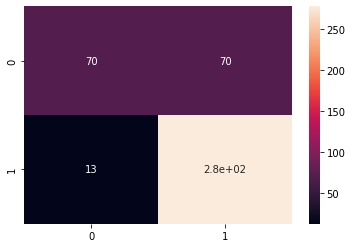

In [ ]:
# The model performs poorly in terms of false negatives
sns.heatmap(confusion_matrix(test_y, test_preds), annot=True)

In [ ]:
f1_score(test_y, test_preds, average="macro")

0.748956118374422